In [96]:
!kaggle datasets download -d jaidalmotra/weed-detection

Dataset URL: https://www.kaggle.com/datasets/jaidalmotra/weed-detection
License(s): CC-BY-NC-SA-4.0
weed-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip /content/weed-detection.zip

Archive:  /content/weed-detection.zip
  inflating: test/_annotations.coco.json  
  inflating: test/ridderzuring_3109_jpg.rf.b8e99770acf95370b238f2af2a71f5a3.jpg  
  inflating: test/ridderzuring_3123_jpg.rf.dec89676b33f976690aabf25128a32ae.jpg  
  inflating: test/ridderzuring_3126_jpg.rf.8980b3ae3ec4ecd023aab5bc54c26089.jpg  
  inflating: test/ridderzuring_3128_jpg.rf.3df60a441016955fbf62fc335db58f9d.jpg  
  inflating: test/ridderzuring_3129_jpg.rf.d376edabc61dc552b7f6671377a0ec98.jpg  
  inflating: test/ridderzuring_3132_jpg.rf.3e9ea76cf7c71c600deb988d67eac2ad.jpg  
  inflating: test/ridderzuring_3133_jpg.rf.5c8cd3580345823bfdc4fea6b7c4a55b.jpg  
  inflating: test/ridderzuring_3134_jpg.rf.33c8c3b64b84bc37707d1ae492358041.jpg  
  inflating: test/ridderzuring_3136_jpg.rf.e6dfee17f1b34aec0eb6f5db5c0a8743.jpg  
  inflating: test/ridderzuring_3137_jpg.rf.45eb60ce06dae131686009b7d33066e5.jpg  
  inflating: test/ridderzuring_3140_jpg.rf.1bb92c730b1b7f7053fae4c7b38de457.jpg  
  inflating: test

In [106]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

from torchvision.ops import box_iou
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

In [98]:
# Preprocessing and loading the images

class ObjectDetectionDataset(Dataset):
    def __init__(self, json_file, images_dir):
        self.images_dir = images_dir

        with open(json_file, 'r') as file:
            self.data = json.load(file)

        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.categories = self.data['categories']

        self.target_size = (20, 20)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.target_size)
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_info = self.images[index]
        image_id = image_info['id']
        image_path = os.path.join(self.images_dir, image_info['file_name'])

        # Load the image
        image = Image.open(image_path).convert('RGB')

        # Convert the image to a tensor
        image = self.transform(image)

        # Get all annotations for the current image
        image_annotations = [ann for ann in self.annotations if ann['image_id'] == image_id]

        # Extract bounding boxes, class labels, and areas
        bboxes = []
        labels = []
        areas = []
        for ann in image_annotations:
            bbox = ann['bbox']
            # Convert bbox to [x_min, y_min, x_max, y_max]
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height

            # Check for valid bounding box dimensions
            if width > 0 and height > 0:
                bboxes.append([x_min, y_min, x_max, y_max])
                labels.append(ann['category_id'])
                areas.append(ann['area'])

        # If no valid bounding boxes, skip this sample
        if len(bboxes) == 0:
            return None

        # Convert to tensors
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        return image, bboxes, labels, areas

In [99]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    images, bboxes, labels, areas = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, bboxes, labels, areas

In [100]:
class SimpleSSDDetector(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSSDDetector, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.loc_head = nn.Conv2d(128, 4 * 4, kernel_size=3, stride=1, padding=1)
        self.conf_head = nn.Conv2d(128, 4 * num_classes, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.backbone(x)
        loc_output = self.loc_head(x)
        conf_output = self.conf_head(x)

        return loc_output

In [101]:
# Load datasets
dataset = ObjectDetectionDataset('train/_annotations.coco.json', 'train')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataset = ObjectDetectionDataset('test/_annotations.coco.json', 'test')
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [102]:
model = SimpleSSDDetector(num_classes=len(dataset.categories))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Make sure data is loaded correctly and check shape
for images, bboxes, labels, areas in dataloader:
    print(images.shape)
    loc_output, conf_output = model(images)

torch.Size([2, 3, 20, 20])
torch.Size([1, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 20, 20])
t

In [103]:
num_epochs = 2

for epoch in range(num_epochs):
  for images, bboxes, labels, areas in dataloader:
    # Convert bboxes and labels to tensors
    bboxes = pad_sequence(bboxes, batch_first=True)
    labels = pad_sequence(labels, batch_first=True, padding_value=-1)

    # Pass the inputs as a tuple
    loss = model(images)
    loss = loss.mean()

    # Backpropagate and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model
torch.save(model.state_dict(), 'ssd.pth')

Epoch [1/2], Loss: 0.0040
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: -0.0007
Epoch [1/2], Loss: -0.0015
Epoch [1/2], Loss: -0.0024
Epoch [1/2], Loss: -0.0032
Epoch [1/2], Loss: -0.0041
Epoch [1/2], Loss: -0.0050
Epoch [1/2], Loss: -0.0059
Epoch [1/2], Loss: -0.0069
Epoch [1/2], Loss: -0.0079
Epoch [1/2], Loss: -0.0089
Epoch [1/2], Loss: -0.0099
Epoch [1/2], Loss: -0.0109
Epoch [1/2], Loss: -0.0119
Epoch [1/2], Loss: -0.0129
Epoch [1/2], Loss: -0.0141
Epoch [1/2], Loss: -0.0151
Epoch [2/2], Loss: -0.0161
Epoch [2/2], Loss: -0.0173
Epoch [2/2], Loss: -0.0184
Epoch [2/2], Loss: -0.0196
Epoch [2/2], Loss: -0.0206
Epoch [2/2], Loss: -0.0218
Epoch [2/2], Loss: -0.0228
Epoch [2/2], Loss: -0.0240
Epoch [2/2], Loss: -0.0251
Epoch [2/2], Loss: -0.0263
Epoch [2/2], Loss: -0.0276
Epoch [2/2]

In [107]:
def evaluate_model(model, dataloader, iou_threshold=0.5, conf_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device
    true_positive, false_positive, false_negative, all_scores = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(list)

    with torch.no_grad():
        for images, bboxes, labels, _ in dataloader:
            images = images.to(device)
            loc_output = model(images)
            decoded_bboxes, decoded_labels, decoded_scores = decode_model_output(loc_output, iou_threshold, conf_threshold)

            for i in range(len(images)):
                gt_bboxes, gt_labels = bboxes[i], labels[i]
                for label in gt_labels.unique():
                    label = label.item()
                    pred_bboxes, pred_scores = decoded_bboxes[i][decoded_labels[i] == label], decoded_scores[i][decoded_labels[i] == label]
                    ious = box_iou(pred_bboxes, gt_bboxes[gt_labels == label])
                    assigned_gt = torch.zeros_like(pred_scores, dtype=torch.bool)
                    assigned_gt[ious.max(dim=1)[0] >= iou_threshold] = True
                    true_positive[label] += assigned_gt.sum().item()
                    false_positive[label] += (1 - assigned_gt).sum().item()
                    false_negative[label] += (gt_labels == label).sum().item() - assigned_gt.sum().item()
                    all_scores[label].extend(pred_scores.tolist())

    precisions, recalls, f1s, aps = {}, {}, {}, {}
    for label in true_positive:
        precision, recall, _ = precision_recall_curve([0] * len(all_scores[label]) + [1] * true_positive[label], all_scores[label] + [1.0] * true_positive[label])
        precisions[label], recalls[label], f1s[label] = precision, recall, f1_score([0] * len(all_scores[label]) + [1] * true_positive[label], [s >= conf_threshold for s in all_scores[label]] + [True] * true_positive[label])
        aps[label] = average_precision_score([0] * len(all_scores[label]) + [1] * true_positive[label], all_scores[label] + [1.0] * true_positive[label])
    return precisions, recalls, f1s, sum(aps.values()) / len(aps)

def decode_model_output(loc_output, iou_threshold, conf_threshold):
    batch_size, num_anchors, h, w = loc_output.size()
    num_classes=len(dataset.categories)
    loc_output = loc_output.permute(0, 2, 3, 1).reshape(batch_size, h * w * num_anchors, 4)
    conf_output = loc_output.new_zeros(batch_size, h * w * num_anchors, num_classes)
    decoded_bboxes, decoded_labels, decoded_scores = [], [], []
    for i in range(batch_size):
        bboxes, scores = loc_output[i], conf_output[i].softmax(dim=-1)
        keep = scores.max(dim=-1)[0] >= conf_threshold
        bboxes, scores, labels = bboxes[keep], scores[keep], scores.argmax(dim=-1)[keep]
        keep = box_nms(bboxes, scores, iou_threshold)
        decoded_bboxes.append(bboxes[keep])
        decoded_labels.append(labels[keep])
        decoded_scores.append(scores[keep, labels[keep]])
    return decoded_bboxes, decoded_labels, decoded_scores

def box_nms(bboxes, scores, iou_threshold):
    if not bboxes.numel():
        return torch.empty((0,), dtype=torch.long)
    sorted_scores, indices = scores.sort(descending=True)
    ious = box_iou(bboxes[indices], bboxes[indices])
    keep = torch.ones_like(indices, dtype=torch.bool)
    keep[1:] &= (ious[:-1, 1:] < iou_threshold)
    return indices[keep]

In [ ]:
precisions, recalls, f1s, mAP = evaluate_model(model, dataloader)

print("Precision:")
for label, precision in precisions.items():
    print(f"Class {label}: {precision:.3f}")

print("\nRecall:")
for label, recall in recalls.items():
    print(f"Class {label}: {recall:.3f}")

print("\nF1 Score:")
for label, f1 in f1s.items():
    print(f"Class {label}: {f1:.3f}")

print(f"\nMean Average Precision (mAP): {mAP:.3f}")

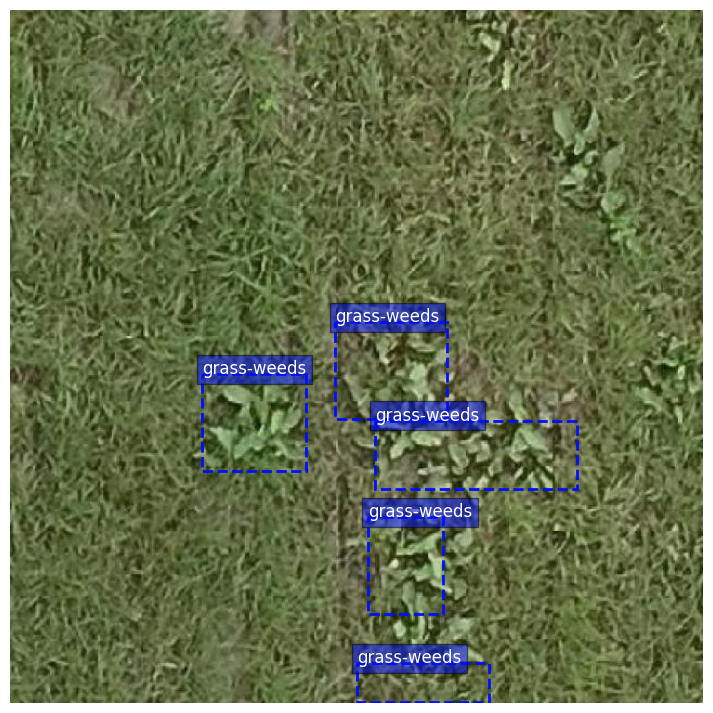

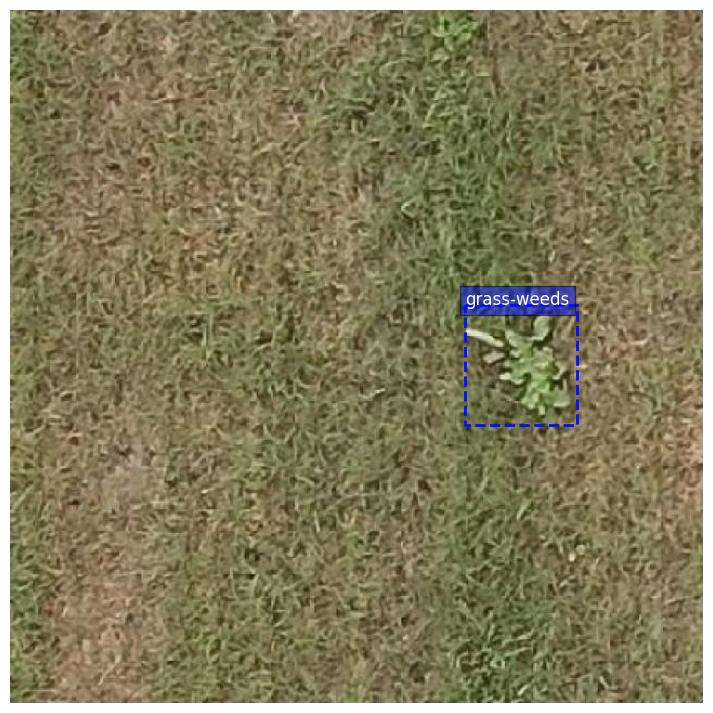

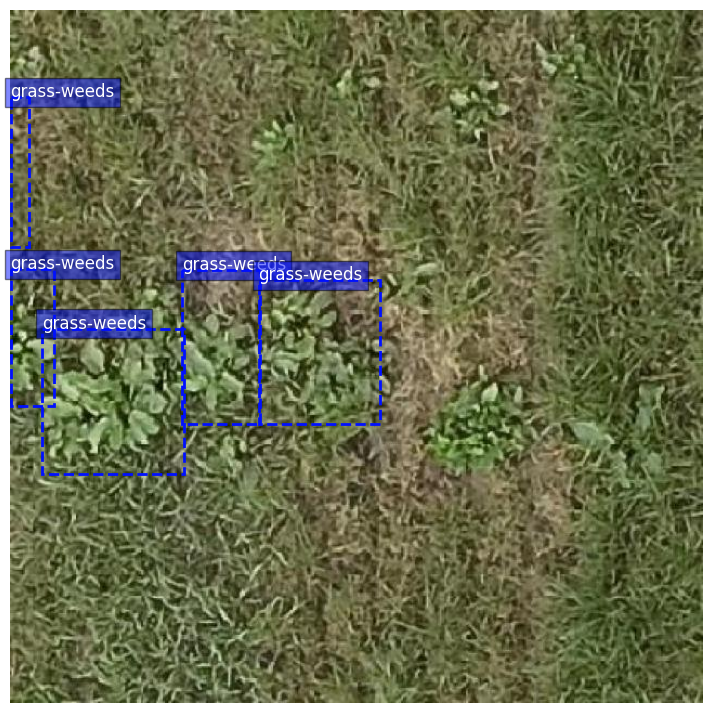

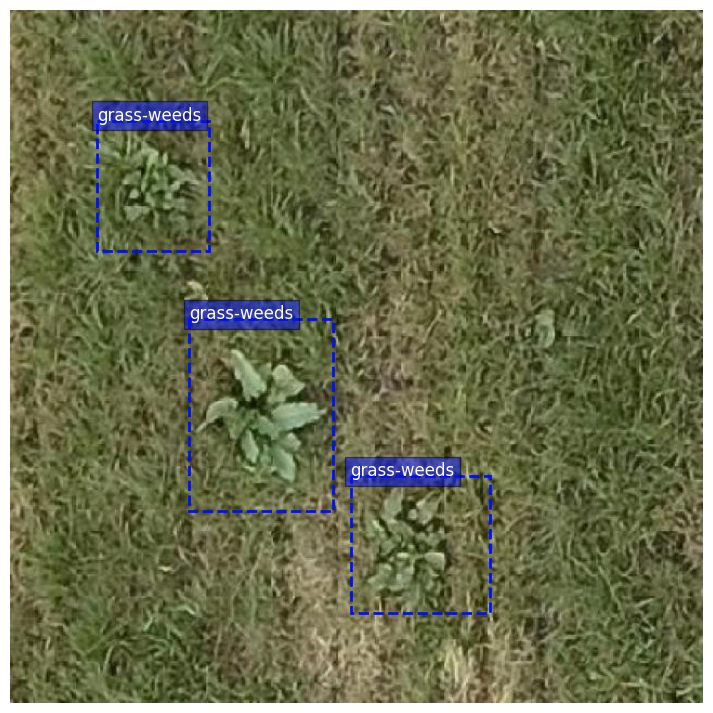

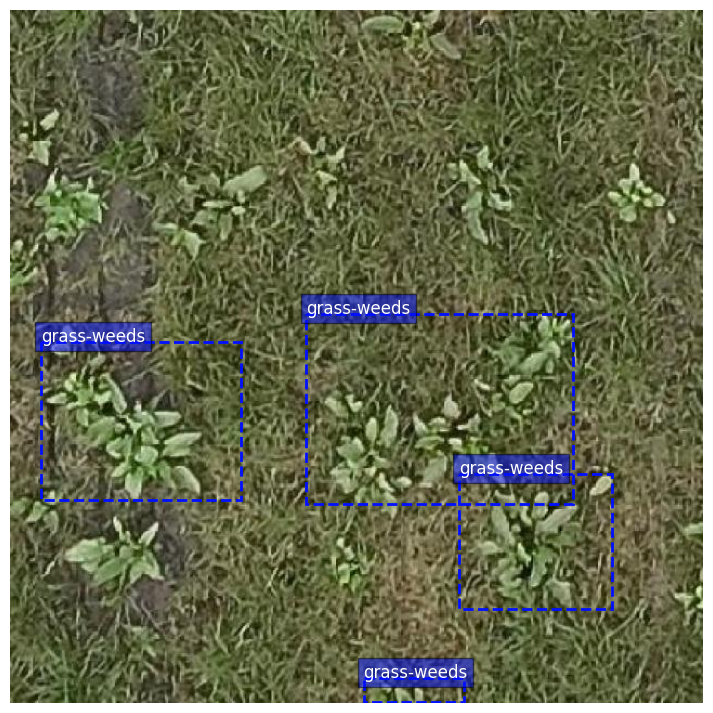

In [ ]:
import seaborn as sns

def visualize_predictions(dataset, model, device, num_images=5):
    model.eval()
    transform = dataset.transform
    for idx in range(num_images):
        image_info = dataset.images[idx]
        image_id = image_info['id']
        image_path = os.path.join(dataset.images_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)

        fig, ax = plt.subplots(1, 1, figsize=(12, 9))
        ax.imshow(image)
        colors = sns.color_palette('hsv', len(dataset.categories))

        # Plot predicted boxes
        boxes = output[0]['boxes'].cpu().numpy()
        scores = output[0]['scores'].cpu().numpy()
        labels = output[0]['labels'].cpu().numpy()
        for box, score, label in zip(boxes, scores, labels):
            if score > 0.5:  # Show only high confidence predictions
                color = colors[label % len(colors)]
                ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                           fill=False, color=color, linewidth=2))
                ax.text(box[0], box[1], f'{dataset.categories[label-1]["name"]}: {score:.2f}',
                        bbox=dict(facecolor=color, alpha=0.5), fontsize=12, color='white')

        # Plot ground truth boxes
        image_annotations = [ann for ann in dataset.annotations if ann['image_id'] == image_id]
        for ann in image_annotations:
            box = ann['bbox']
            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            color = colors[ann['category_id'] % len(colors)]
            ax.add_patch(plt.Rectangle((x_min, y_min), width, height,
                                       fill=False, edgecolor=color, linewidth=2, linestyle='--'))
            ax.text(x_min, y_min, dataset.categories[ann['category_id']-1]['name'],
                    bbox=dict(facecolor=color, alpha=0.5), fontsize=12, color='white')

        plt.axis('off')
        plt.show()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Visualize sample predictions
visualize_predictions(val_dataset, model, device, num_images=5)
